# MoCo

In this notebook, we are going to reproduce [MoCo](https://arxiv.org/pdf/1911.05722) on the image dataset [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10). Without heavy tuning of hyperparameters, the pretrained MoCo model can achieve more than $45\%$ classification accuracy on CIFAR10 within $0.5$ 4090 hours by simply adding a single linear layer of prediction head.

First, we can try to get a $5\times 5$ sample from the CIFAR10 dataset. Please run the following cell to ensure the dataset and all necessary packages are installed.

/tmp/ipykernel_3018/789973083.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Files already downloaded and verified


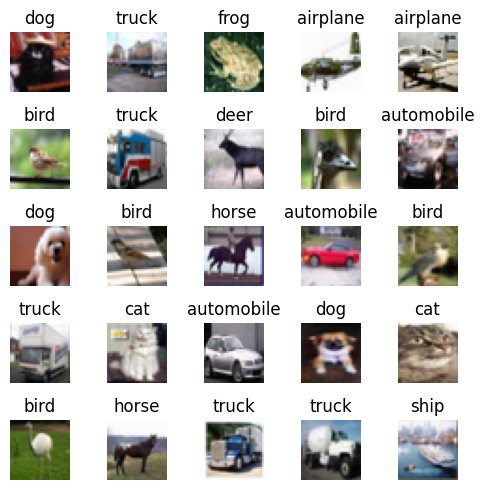

In [1]:
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from utils import save_model, load_model, train_set, sample_data
from model import CustomResNet, create_resnet_encoder
import yaml
from torch.utils.tensorboard import SummaryWriter

sample_data(5, 5)

The key contribution of MoCo is its innovative approach of **contrastive learning**. Contrastive learning is an unsupervised learning method, intended to **learn a good representation (feature)** for each image. A great feature function $f$ should satisfy:

- When two images are _similar_, they have _similar_ $f$ values.
- When two images are _different_ (e.g., showing different objects), they have _almost orthogonal_ $f$ values.

In MoCo, we want to learn such feature function $f_\theta$. 

To learn $\theta$, we can use **InfoNCE loss** as the objective: for a similar image pair $(p,q_0)$ and several negative samples $q_1,q_2,\cdots,q_K$, the loss is defined as
$$\mathcal L=-\log \dfrac{\exp\{f(p)^Tf(q)/\tau\}}{\sum_{i=0}^K \exp\{f(p)^Tf(q_i)/\tau\}}.$$
A problem is, how to define those negative samples $q_i$ ($1\le i\le K$)? Intuitively we need $K$ to be large enough; but when the size of $\theta$ is large, it will be time-consuming to compute all $f_\theta(q_i)$.

Key idea: maintain a **replay buffer** of negative samples. When a batch of $f(q)$ is computed, add them into the queue, so that they can be used as negative samples in the following batches. 

However, since $\theta$ is updating, the old negative features may come from very different parameters $\theta_{\text{old}}$, making the loss function diverge from the true InfoNCE. Thus, we made two actions:

- These old features should be popped out, i.e. make the buffer a **queue**.
- Separate the **query encoder** and the **key encoder**. Here, query encoder $f_q$ just encodes $p$, and the key encoder $f_k$ encodes $q_0,q_1,\cdots,q_K$. To make $f_k$ moving slowly while close to $f_q$, we use the **momentum update method**: 
    $$f_k\leftarrow mf_k+(1-m)f_q$$
    after training a batch.

Creating a positive sample $q_0$ is easy: we can just let $p$ and $q_0$ be two random transformations of the same image.

Please refer to the following code for details.

In [2]:
class MoCo(nn.Module):
    def __init__(self, encoder_q, encoder_k, dim=128, queue_size=2000, momentum=0.999, tau=0.07):
        super(MoCo, self).__init__()
        self.queue_size = queue_size
        self.momentum = momentum
        self.tau = tau
        self.dim = dim
        self.encoder_q = encoder_q
        self.encoder_k = encoder_k
        self.register_buffer("queue", torch.randn(dim, queue_size))
        self.queue = F.normalize(self.queue, dim=0)
        self.queue_ptr = 0
        print(f"MoCo Info: queue size {queue_size}, momentum {momentum}, tau {tau}, dim {dim}.")
        print(f"MoCo total params: {sum(p.numel() for p in self.parameters())}")

    @torch.no_grad()
    def _momentum_update(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.momentum + param_q.data * (1. - self.momentum)

    @torch.no_grad()
    def _push(self, keys):
        batch_size = keys.shape[0]
        assert self.queue_size % batch_size == 0, f"queue size should be divisible by batch size, got {self.queue_size} and {batch_size}."
        if keys.shape == (batch_size, self.dim):
            self.queue[:, self.queue_ptr : self.queue_ptr + batch_size] = keys.transpose(0, 1)
        elif keys.shape == (self.dim, batch_size):
            self.queue[:, self.queue_ptr : self.queue_ptr + batch_size] = keys
        else:
            raise ValueError(f"Invalid shape of keys: {keys.shape}, expected {(batch_size, self.dim)} or {(self.dim, batch_size)} to match the queue size.")
        self.queue_ptr = (self.queue_ptr + batch_size) % self.queue_size

    def forward(self, im_q, im_k):
        q = self.encoder_q(im_q)
        q = F.normalize(q, dim=1)
        with torch.no_grad():
            self._momentum_update()
            k = self.encoder_k(im_k)
            k = F.normalize(k, dim=1)
            self._push(k)
        
        l_pos = torch.bmm(q.view(q.shape[0], 1, -1), k.view(k.shape[0], -1, 1)).squeeze(-1)
        l_neg = torch.mm(q, self.queue.clone().detach())
        logits = torch.cat([l_pos, l_neg], dim=1) / self.tau
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)
        return logits, labels

To test MoCo, we can do the following steps:

- Train a MoCo model $\mathcal M$ (label cannot be used in this stage);
- Directly use the output of $\mathcal M$ as the images features;
- Add a classification head (only one feed-forward layer) after MoCo, then train this head while keep the parameters of $\mathcal M$ fixed.

For random features, only applying one feed-forward layer will lead to bad performance (usually less than $20\%$ accuracy). However, we will see that using the feature provided by MoCo, a simple head can achieve $45\%$ accuracy.

In [3]:
class ClassificationHead(nn.Module):
    def __init__(self, dim=128, num_classes=10):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

Now comes the training part. First, read all hyperparameters in `config.yaml`, and set seeds and the device. 

Feel free to tune the hyperparameters and do your own experiments!

In [4]:
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

seed = config['seed']
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

if config['device'] == 'cuda' and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Now we write `valid()` to test the performance of MoCo at post-training. Here, `model` is the pretrained MoCo model, we should keep it fixed in this function. Assume that the `post_train_loader` and `test_loader` yield the data of the format `(image, label)`.

In [5]:
def valid(model, post_train_loader, test_loader, criterion):
    classification_head = ClassificationHead(dim=config['moco']['dim'], num_classes=10).to(device)
    post_optimizer = torch.optim.SGD(classification_head.parameters(), lr=config['post_train']['optimizer']['lr'], momentum=config['post_train']['optimizer']['momentum'], weight_decay=config['post_train']['optimizer']['weight_decay'])

    for param in model.encoder_q.parameters():
        param.requires_grad = False

    for epoch in range(config['post_train']['num_epochs']):
        classification_head.train()
        sum_loss = 0.0
        length = 0
        pbar = tqdm(total=len(post_train_loader.dataset))
        for inputs, targets in post_train_loader:
            length += inputs.size(0)
            inputs, targets = inputs.to(device), targets.to(device)
            features = model.encoder_q(inputs)
            outputs = classification_head(features)
            loss = criterion(outputs, targets)
            sum_loss += loss.item()
            post_optimizer.zero_grad()
            loss.backward()
            post_optimizer.step()
            pbar.update(inputs.size(0))
            pbar.set_description(f"Epoch [{epoch+1}/{config['post_train']['num_epochs']}], Loss: {sum_loss / length:.4f}")
        pbar.close()

    classification_head.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(total=len(test_loader.dataset))
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            features = model.encoder_q(inputs)
            outputs = classification_head(features)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            pbar.update(inputs.size(0))
            pbar.set_description(f"Validating, Loss: {total_loss / total:.4f}, Accuracy: {100. * correct / total:.2f}")
    pbar.close()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    
    for param in model.encoder_q.parameters():
        param.requires_grad = True
    return avg_loss, accuracy

Now we write the most important function: `train()`. Assume the `train_loader` yields the data of the format `(image_query,image_key)`.

In [6]:
def train(model, train_loader, post_train_loader, test_loader, criterion, optimizer, num_epochs, save_interval, writer):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.
        length = 0
        pbar = tqdm(total=len(train_loader.dataset))
        for _, (im_q, im_k) in enumerate(train_loader):
            length += 1
            im_q, im_k = im_q.to(device), im_k.to(device)
            
            logits, labels = model(im_q, im_k)
            loss = F.cross_entropy(logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pbar.update(im_q.shape[0])
            pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / length:.4f}")
            
        pbar.close()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        writer.add_scalar('Loss/train', avg_loss, epoch + 1)

        if (epoch + 1) % save_interval == 0:
            save_model(f'./checkpoints/moco_epoch_{epoch+1}.pth', model)
            print(f"Model saved at epoch {epoch+1}")
            print(f"Validating model at epoch {epoch+1}")
            test_loss, test_accuracy = valid(model, post_train_loader, test_loader, criterion)
            print(f"Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.2f}%")
            writer.add_scalar('Loss/valid', test_loss, epoch + 1)
            writer.add_scalar('Accuracy/valid', test_accuracy, epoch + 1)

    writer.close()

The query and key encoder are all ResNets. The structure is defined in `model.py`. Feel free to modify them!

After running the following code block, you will see the configurations of MoCo and the total number of parameters.

In [7]:
encoder_q = create_resnet_encoder()
encoder_k = create_resnet_encoder()
model = MoCo(encoder_q, encoder_k, dim=config['moco']['dim'], queue_size=config['moco']['queue_size'], momentum=config['moco']['momentum'], tau=config['moco']['tau']).to(device)

MoCo Info: queue size 5000, momentum 0.999, tau 0.07, dim 128.
MoCo total params: 6612096


Define the datasets. Note that we should apply two random transformations to the original dataset. Class `AugmentedDataset` serves to change the format of the original dataset.

In [8]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        im_q = self.transform(img)
        im_k = self.transform(img)
        return im_q, im_k

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=config['aug']['random_crop']['padding']),
    transforms.RandomHorizontalFlip() if config['aug']['random_horizontal_flip'] else lambda x: x,
    transforms.RandomApply([transforms.ColorJitter(config['aug']['color_jitter']['brightness'], config['aug']['color_jitter']['contrast'], config['aug']['color_jitter']['saturation'], config['aug']['color_jitter']['hue'])], p=config['aug']['color_jitter']['probability']),
    transforms.RandomGrayscale(p=config['aug']['random_grayscale']['probability']),
    # transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [9]:
train_dataset = AugmentedDataset(train_set, train_transform)
train_loader = DataLoader(train_dataset, batch_size=config['dataloader']['batch_size'], shuffle=True, num_workers=config['dataloader']['num_workers'])
post_train_loader = DataLoader(train_set, batch_size=config['dataloader']['batch_size'], shuffle=True, num_workers=config['dataloader']['num_workers'])
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=config['dataloader']['batch_size'], shuffle=False, num_workers=config['dataloader']['num_workers'])

Files already downloaded and verified


In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=config['optimizer']['lr'], momentum=config['optimizer']['momentum'], weight_decay=config['optimizer']['weight_decay'])
criterion = nn.CrossEntropyLoss()
num_epochs = config['train']['num_epochs']
save_interval = config['train']['save_interval']
writer = SummaryWriter(log_dir='./logs')

Everything is ready now -- it is time to train!

**Note**: the code uses `tensorboard` to record the training curves. To visualize train loss curves, validation loss and accuracy curves, please run `tensorboard --logdir logs` in command line.

In [11]:
train(model, train_loader, post_train_loader, test_loader, criterion, optimizer, num_epochs, save_interval, writer)

Epoch [1/200], Loss: 8.3347: 100%|██████████| 50000/50000 [00:09<00:00, 5165.16it/s]


Epoch [1/200], Loss: 8.3347


Epoch [2/200], Loss: 8.5167: 100%|██████████| 50000/50000 [00:08<00:00, 5859.23it/s]


Epoch [2/200], Loss: 8.5167


Epoch [3/200], Loss: 8.5166: 100%|██████████| 50000/50000 [00:09<00:00, 5068.31it/s]


Epoch [3/200], Loss: 8.5166


Epoch [4/200], Loss: 8.5150: 100%|██████████| 50000/50000 [00:08<00:00, 5635.63it/s]


Epoch [4/200], Loss: 8.5150


Epoch [5/200], Loss: 8.4883: 100%|██████████| 50000/50000 [00:09<00:00, 5159.22it/s]


Epoch [5/200], Loss: 8.4883


Epoch [6/200], Loss: 8.2176: 100%|██████████| 50000/50000 [00:09<00:00, 5157.58it/s]


Epoch [6/200], Loss: 8.2176


Epoch [7/200], Loss: 7.9001: 100%|██████████| 50000/50000 [00:08<00:00, 5657.14it/s]


Epoch [7/200], Loss: 7.9001


Epoch [8/200], Loss: 7.4220: 100%|██████████| 50000/50000 [00:10<00:00, 4979.51it/s]


Epoch [8/200], Loss: 7.4220


Epoch [9/200], Loss: 7.0017: 100%|██████████| 50000/50000 [00:09<00:00, 5142.82it/s]


Epoch [9/200], Loss: 7.0017


Epoch [10/200], Loss: 6.6268: 100%|██████████| 50000/50000 [00:09<00:00, 5035.61it/s]


Epoch [10/200], Loss: 6.6268
Model saved at epoch 10
Validating model at epoch 10


Epoch [20/50], Loss: 0.3130:   0%|          | 0/50000 [00:02<?, ?it/s]

KeyboardInterrupt: 